# Paso 1: Limpieza del Dataset

## Lectura de los datos

In [1]:
## Leer Train dataset 

import pandas as pd

dataset_train = pd.read_csv("../files/input/train_data.csv.zip")
train = dataset_train
train.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,10748,310000,1,3,1,32,0,0,0,0,...,84373,57779,14163,8295,6000,4000,3000,1000,2000,0
1,12574,10000,2,3,1,49,-1,-1,-2,-1,...,1690,1138,930,0,0,2828,0,182,0,1
2,29677,50000,1,2,1,28,-1,-1,-1,0,...,45975,1300,43987,0,46257,2200,1300,43987,1386,0
3,8857,80000,2,3,1,52,2,2,3,3,...,40748,39816,40607,3700,1600,1600,0,1600,1600,1
4,21099,270000,1,1,2,34,1,2,0,0,...,22448,15490,17343,0,4000,2000,0,2000,2000,0


In [2]:
## Leer Test dataset 

import pandas as pd

dataset_test = pd.read_csv("../files/input/test_data.csv.zip")
test = dataset_test
test.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
1,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0
2,11,200000,2,3,2,34,0,0,2,0,...,2513,1828,3731,2306,12,50,300,3738,66,0
3,15,250000,1,1,2,29,0,0,0,0,...,59696,56875,55512,3000,3000,3000,3000,3000,3000,0
4,16,50000,2,3,3,23,1,2,0,0,...,28771,29531,30211,0,1500,1100,1200,1300,1100,0


In [3]:
train.shape


(21000, 25)

In [4]:
test.shape

(9000, 25)

## Limpieza

In [5]:
# Renombre la columna "default payment next month" a "default"
train.rename(columns={"default payment next month": "default"}, inplace=True)
test.rename(columns={"default payment next month": "default"}, inplace=True)

In [6]:
# Remueva la columna "ID"
train.drop(columns=["ID"], inplace=True)
test.drop(columns=["ID"], inplace=True)

In [9]:
# Elimine los registros con informacion no disponible.
train = train.loc[train['EDUCATION'] != 0]
test = test.loc[test['EDUCATION'] != 0]

train = train.loc[train['MARRIAGE'] != 0]
test = test.loc[test['MARRIAGE'] != 0]

In [10]:
# Para la columna EDUCATION, valores > 4 indican niveles superiores
# de educación, agrupe estos valores en la categoría "others".
train.loc[train['EDUCATION'] > 4, 'EDUCATION'] = 4
test.loc[test['EDUCATION'] > 4, 'EDUCATION'] = 4

# Paso 2: División del Dataset

In [11]:
# Divida los datasets en x_train, y_train, x_test, y_test.
x_train = train.drop(columns=['default'])
y_train = train['default']

x_test = test.drop(columns=['default'])
y_test = test['default']

# Paso 3: Modelo de Clasificación

In [12]:
# Cree un pipeline para el modelo de clasificación. Este pipeline debe
# contener las siguientes capas:
# - Transforma las variables categoricas usando el método
#   one-hot-encoding.
# - Ajusta un modelo de bosques aleatorios (rando forest).

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Identificar columnas categóricas
categoricas = ['SEX', 'EDUCATION', 'MARRIAGE']

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categoricas),
    ],
    remainder= 'passthrough',
)

# Modelo
RFC = RandomForestClassifier(random_state=42)

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('classifier', RFC)
])

# Paso 4: Optimización

In [13]:
# Optimice los hiperparametros del pipeline usando validación cruzada.
# Use 10 splits para la validación cruzada. Use la función de precision
# balanceada para medir la precisión del modelo.

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Busqueda de hiperparámetros
param_grid = {
    'classifier__n_estimators': [50, 100],          # Número de árboles en el bosque
    'classifier__max_depth': [None],         # Profundidad máxima del árbol
    'classifier__min_samples_split': [2, 4, 6],         # Número mínimo de muestras para dividir un nodo
    'classifier__min_samples_leaf': [1],            # Número mínimo de muestras en una hoja
    'classifier__max_features' : ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    pipeline,                      
    param_grid,                    
    cv=10,                         
    scoring= 'balanced_accuracy',  
    verbose=2,                     
    n_jobs=-1                      
)

grid_search.fit(x_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión balanceada (validación):", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Mejores hiperparámetros: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100}
Precisión balanceada (validación): 0.6599010214867194


In [31]:
print(grid_search.score(x_train,y_train),grid_search.score(x_test,y_test))

0.9434009087435264 0.6707404078201706


In [14]:
#Modelo entrenado
final_model = grid_search.best_estimator_

# Paso 5: Guardar el Modelo

In [42]:
# Guarde el modelo (comprimido con gzip) como "files/models/model.pkl.gz".
# Recuerde que es posible guardar el modelo comprimido usanzo la libreria gzip.

import gzip
import pickle

output_path = "C:/Users/Asus/Documents/GitHub/2024-2-LAB-01-prediccion-del-default-usando-rf-nathalygarzon/files/models/model.pkl.gz"
with gzip.open(output_path, 'wb') as file:
    pickle.dump(final_model, file)


# Paso 6: Métricas

In [43]:
# Calcule las metricas de precision, precision balanceada, recall,
# y f1-score para los conjuntos de entrenamiento y prueba.

from sklearn.metrics import precision_score, balanced_accuracy_score, recall_score, f1_score

# Realizar las predicciones sobre los conjuntos de entrenamiento y prueba
y_train_pred = final_model.predict(x_train)
y_test_pred = final_model.predict(x_test)

# Calcular métricas para el conjunto de entrenamiento
precision_train = precision_score(y_train, y_train_pred)
balanced_accuracy_train = balanced_accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
precision_test = precision_score(y_test, y_test_pred)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Mostrar los resultados
print("Métricas para el conjunto de entrenamiento:")
print(f"Precisión: {precision_train:.4f}")
print(f"Precisión balanceada: {balanced_accuracy_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")

print("\nMétricas para el conjunto de prueba:")
print(f"Precisión: {precision_test:.4f}")
print(f"Precisión balanceada: {balanced_accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-score: {f1_test:.4f}")



Métricas para el conjunto de entrenamiento:
Precisión: 0.9936
Precisión balanceada: 0.9434
Recall: 0.8885
F1-score: 0.9381

Métricas para el conjunto de prueba:
Precisión: 0.6524
Precisión balanceada: 0.6707
Recall: 0.3987
F1-score: 0.4950


In [44]:
# Guardelas en el archivo files/output/metrics.json. Cada fila
# del archivo es un diccionario con las metricas de un modelo.
# Este diccionario tiene un campo para indicar si es el conjunto
# de entrenamiento o prueba. Por ejemplo:
#
# {'dataset': 'train', 'precision': 0.8, 'balanced_accuracy': 0.7, 'recall': 0.9, 'f1_score': 0.85}
# {'dataset': 'test', 'precision': 0.7, 'balanced_accuracy': 0.6, 'recall': 0.8, 'f1_score': 0.75}

import json

output_path = "C:/Users/Asus/Documents/GitHub/2024-2-LAB-01-prediccion-del-default-usando-rf-nathalygarzon/files/output/metrics.json"

metrics = [
    {
        "type": "metrics",
        'dataset': 'train',
        'precision': precision_train,
        'balanced_accuracy': balanced_accuracy_train,
        'recall': recall_train,
        'f1_score': f1_train
    },
    {
        "type": "metrics",
        'dataset': 'test',
        'precision': precision_test,
        'balanced_accuracy': balanced_accuracy_test,
        'recall': recall_test,
        'f1_score': f1_test
    }
]

# Guardar las métricas en el archivo JSON
with open(output_path, 'w') as file:
    json.dump(metrics, file, indent=4)


# Paso 7: Matriz de confusión

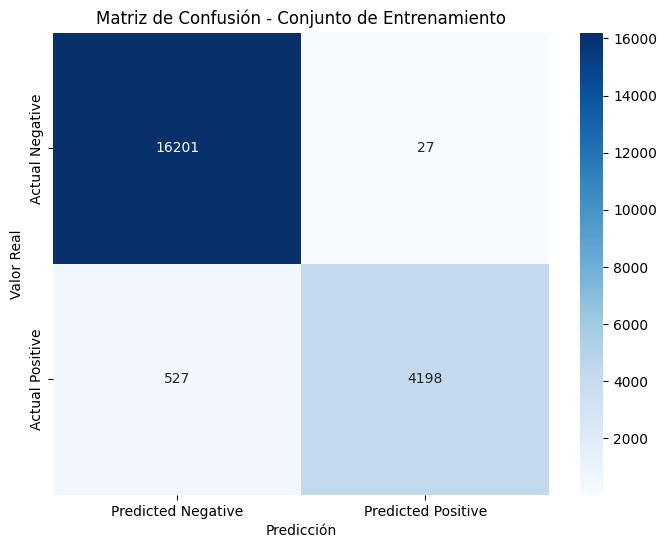

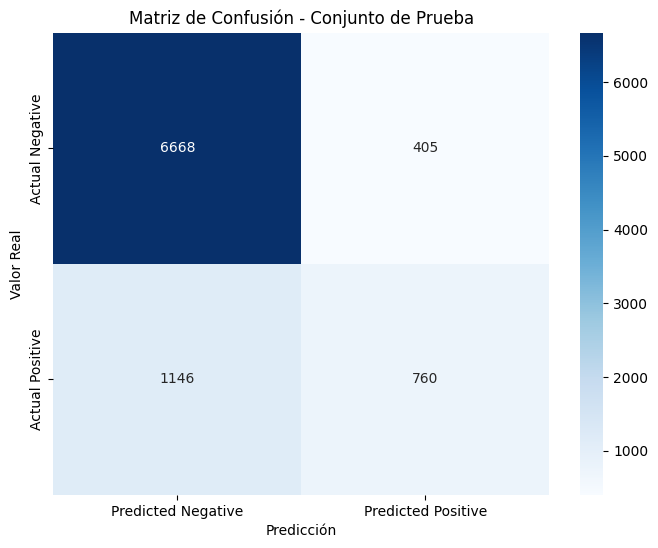

In [45]:
#Calcule las matrices de confusion para los conjuntos de entrenamiento y prueba.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión para el conjunto de entrenamiento
matriz_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_train, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Matriz de Confusión - Conjunto de Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Matriz de confusión para el conjunto de prueba
matriz_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_test, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

In [46]:
#Guardelas en el archivo files/output/metrics.json. Cada fila
# del archivo es un diccionario con las metricas de un modelo.
# de entrenamiento o prueba. Por ejemplo:
#
# {'type': 'cm_matrix', 'dataset': 'train', 'true_0': {"predicted_0": 15562, "predicte_1": 666}, 'true_1': {"predicted_0": 3333, "predicted_1": 1444}}
# {'type': 'cm_matrix', 'dataset': 'test', 'true_0': {"predicted_0": 15562, "predicte_1": 650}, 'true_1': {"predicted_0": 2490, "predicted_1": 1420}}
#

matriz_metrics = [
    {
        'type': 'cm_matrix',
        'dataset': 'train',
        'true_0': {
            'predicted_0': int(matriz_train[0, 0]),
            'predicted_1': int(matriz_train[0, 1])
        },
        'true_1': {
            'predicted_0': int(matriz_train[1, 0]),
            'predicted_1': int(matriz_train[1, 1])
        }
    },
    {
        'type': 'cm_matrix',
        'dataset': 'test',
        'true_0': {
            'predicted_0': int(matriz_test[0, 0]),
            'predicted_1': int(matriz_test[0, 1])
        },
        'true_1': {
            'predicted_0': int(matriz_test[1, 0]),
            'predicted_1': int(matriz_test[1, 1])
        }
    }
]

metrics.extend(matriz_metrics)

output_path = "C:/Users/Asus/Documents/GitHub/2024-2-LAB-01-prediccion-del-default-usando-rf-nathalygarzon/files/output/metrics.json"

with open(output_path, 'w') as file:
    json.dump(metrics, file, indent=4)